# Demonstration of PCA

Please note that this notebook is not assessed. We will touch on topics that we do not cover in this specialization, including dataframes, machine learning algorithms, etc. While we encourage you to go through this notebook as it will give you an idea about how PCA is used in real life, feel free to skip this notebook if you are unable to follow it.

## Learning objectives

1. Understanding and interpreting the correlation between different features of a dataset.
2. Applying PCA on a real world dataset and understanding how much data is stored in which components.
3. Visualizing high dimensional data by first reducing it to two dimensions by using PCA and then plotting it.
4. Observing how the performance of a model varies with the number of principle components used.

Two of the uses of PCA are to visualize high dimensional datasets and improve the training speed of machine learning models. In this notebook, we will demonstrate how PCA helps us with both of these.

We will analyze the breast cancer dataset of sklearn. We will first load the dataset and split it into the training and test sets. Then, we will perform logistic regression on the training set and evaluate our model on the test set. Having done that, we will visualize and analyze correlations in the data. We would explore how PCA helps us compress the data and project it onto two dimensions so that we can plot it. Lastly, we will perform logistic regression on the compressed data and see how that stacks up against the performance of the model on the original data.

Let's first import the packages we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

We will use the breast cancer dataset of sklearn in this notebook. This dataset contains information about malignant and benign tumours. We aim to create a model which can classify a tumour as being malignant or benign.

## Loading The Dataset

To start off, we will load the dataset and print a short description about it. You are encouraged to read the description before moving ahead.

In [2]:
dat = datasets.load_breast_cancer()
print(dat.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

We will now load the data into a dataframe and print the first 5 entries. Can you guess how some of the these attributes might be related? For example, could mean radius and mean perimeter be linked?

In [3]:
df_all = pd.DataFrame(dat['data'], columns=list(dat['feature_names']))
df_all.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Creating Train and Test Sets

In order to enable our model to make predictions on whether a tumour is malignant or benign, we need to train it from some data. However, to then evaluate the performance of our model, we need to check that it classifies unseen data correctly. That is why we split the data that we have into two sets - the training set and the test set. We train the parameters for the model by using the training set and then evaluate how good is the model using the test set.

We take 70% of the samples into the training set and 30% into the test set, which is conventional for the size of the dataset that we have.

In [4]:
# We do a 70/30 split
TEST_SIZE_RATIO = 0.3

# Setting up X and y
X = df_all
y = pd.Series(list(dat['target']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_RATIO, random_state=0)

# Normalizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

X_train.shape, y_train.shape (398, 30) (398,)
X_test.shape, y_test.shape (171, 30) (171,)


## Performing Logistic Regression

We will now perform Logistic Regression on the unmodified data. For those of you who do not know about Logistic Regression, it is a technique which lets us classify data into different classes. For example, we can get the image of a fruit and try to classify if it is an orange or an apple. In that case the classes are orange and apple.

In this case, the classes are malignant (represented by the number 0) and benign (represented by the number 1). Based on the data, we would try to classify a tumour as being malignant or benign.

In order to evaluate the performance of the model, we will use a metric called the `f1 score`, which assesses how well the model is doing in predicting whether a tumour is malignant or benign and gives a numerical score based on that. We aim to get the f1 score to be as high as possible.

In [5]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train)))
print("Testing score: ", f1_score(y_test, model.predict(X_test)))

Training score:  0.99203187250996
Testing score:  0.981651376146789


When we train the model on the initial (normalized) data, we get a test set score of 98.17%.

## Visualizing Correlation of the Features

We would expect some features to be highly correlated to one another. Let us create a heatmap which will let us visualize the correlation between the different features.

The code for the following function has been taken from [this](https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/sklearn/sklearn_logistic_regression_vs_gbm.ipynb#scrollTo=ayp_TDIq6qJj) notebook.

Function correlation_matrix: X.shape, y.shape, yX.shape: (569, 30) (569,) (569, 31)



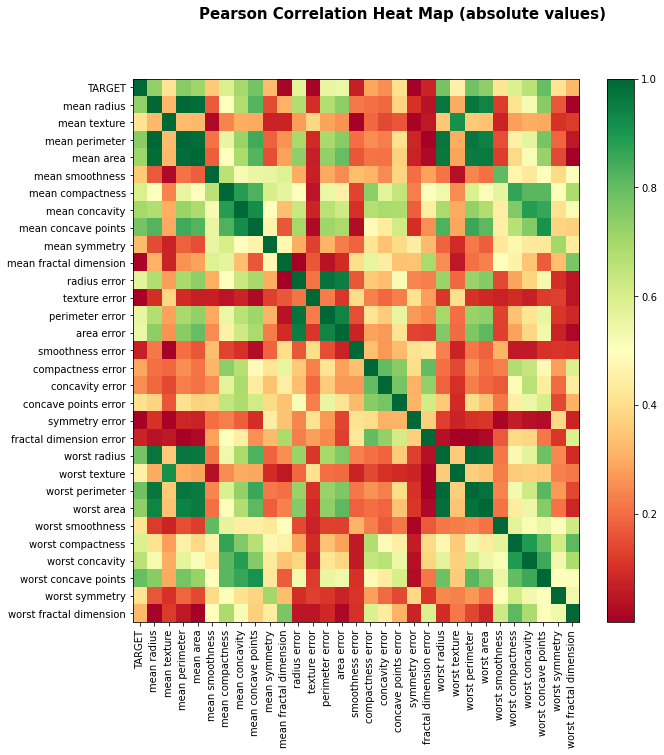

In [6]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(y, X, is_plot=True) 

The `TARGET` label above refers to whether the tumour is malignant(0) or benign(1). Green cells indicate very high correlation whereas red cells indicate very low correlation.

From the above graph, we can see that `mean radius` and `mean perimeter` are very strongly correlated to one another (correlation is almost equal to 1). `mean radius` and `mean area` are very strongly related to one another as well. However, `worst fractal dimension` and `mean radius` are completely unrelated to one another (correlation is almost equal to 0). Can you identify some other features which are very strongly related or unrelated to one another?

We can drop some of these features and combine the others and still lose only minimal amount of information. This is what we will do in the next section when we apply PCA to the data.

## Performing PCA on the Dataset

We will now perform PCA on our training set. This can be done trivially using the sklearn library. Note that the eigenbasis is calculated using only the data points in the training set. This is because the model should perform well on unseen data as well. If we include data about the test set when we find the eigenbasis, then our model might get biased and the test set would no longer provide an unbiased judgement of our model.

We have already normalized the data before and hence we do not need to normalize it again.

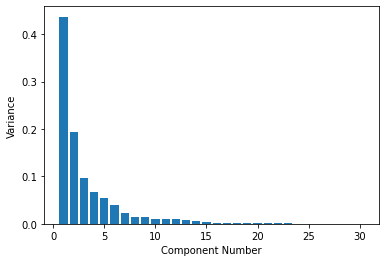

In [7]:
# Applying PCA
pca = PCA()
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Plotting the amount of information stored in each component
plt.ylabel('Variance')
plt.xlabel('Component Number')
plt.bar(np.arange(30) + 1, pca.explained_variance_ratio_)
plt.show()

As you can see, the amount of information stored in a component is really high for the first few dimensions, but then it falls down very rapidly. Only 1.4% of the variance is stored in the 7th component. Moreover, it falls to a completely insignificant 0.25% in the 16th component. We retain alomst 85% of the variance of the original data by using only 5 components, which is one-sixth of the number of features of the original data.

We are printing the numerical values of the variance stored in each component below, should you wish to view them.

In [8]:
print(pca.explained_variance_ratio_)

[4.36893153e-01 1.94151626e-01 9.66154484e-02 6.71661075e-02
 5.49883033e-02 4.01225718e-02 2.18306816e-02 1.48922601e-02
 1.37410827e-02 1.10137130e-02 1.04826288e-02 9.16214247e-03
 7.66306051e-03 5.14226331e-03 3.19635178e-03 2.51968451e-03
 1.92415148e-03 1.65844223e-03 1.49026749e-03 1.06777316e-03
 1.01725216e-03 8.48954816e-04 7.43492725e-04 5.81295611e-04
 5.44222785e-04 2.53545469e-04 2.14385701e-04 4.62967124e-05
 2.51158320e-05 3.72534805e-06]


## Visualizing the Data

One of the uses of PCA is that it lets us visualize high dimensional data.

PCA lets us project our original data into a two dimensional space. This lets us visualize the data by plotting it on a graph. Below, we will visualize the training set by performing PCA on it and only considering the first 2 components.

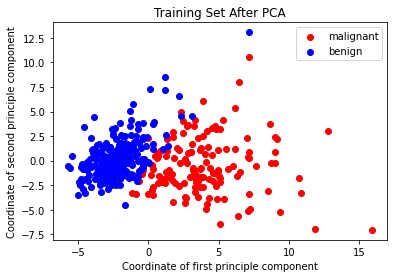

In [9]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

X_train_reduced_malignant = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 0])
X_train_reduced_benign = np.array([x for x, y in zip(X_train_reduced, y_train) if y == 1])

plt.scatter(*X_train_reduced_malignant.T, color='red')
plt.scatter(*X_train_reduced_benign.T, color='blue')
plt.title('Training Set After PCA')
plt.legend(['malignant', 'benign'])
plt.xlabel('Coordinate of first principle component')
plt.ylabel('Coordinate of second principle component')
plt.show()

## Performing Logistic Regression

We will now perform logistic regression again, but this time we will first perform PCA on the data and only consider the first 5 components.

In [10]:
pca = PCA(n_components=5)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
print("Training score: ", f1_score(y_train, model.predict(X_train_reduced)))
print("Testing score: ", f1_score(y_test, model.predict(X_test_reduced)))

Training score:  0.9859719438877755
Testing score:  0.9769585253456222


This time we get a test set score of 97.7%, which is only marginally worse than the original score of 98.17%. However, by using only one-sixth of the amount of data we had initially used, our model shall be trained much faster. While the effect might not be noticeable in this case, it can be huge in certain applications, where the models might have taken many days to train otherwise.

We encourage you to vary the value of `n_components` in the code above and see how the test set accuracy changes. In particular, notice that by using just a single component, we already get a score of 91.59%. Moreover, if we use 14 components, we get a score of 98.17%, which is equal to what we got for the original data, but uses less than half the number of features.

We plot the training score and test score against the number of components. Note that while the training score and test score generally increase with an increase in the number of components, this does not always have to hold. In practice, you need to experiment with different values of `n_components` and find out what works for the specific problem that you are trying to solve.

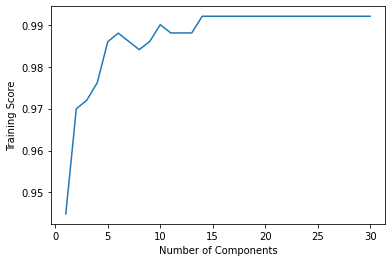

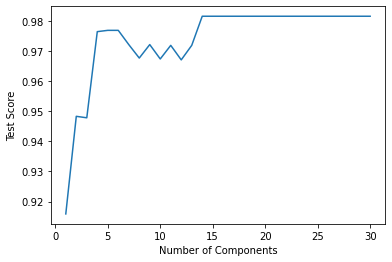

In [11]:
X = np.arange(30) + 1
Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_train, model.predict(X_train_reduced)))

plt.plot(X, Y)
plt.xlabel('Number of Components')
plt.ylabel('Training Score')
plt.show()

Y = []

for i in X:
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    model = LogisticRegression(random_state=0).fit(X_train_reduced, y_train)
    Y.append(f1_score(y_test, model.predict(X_test_reduced)))

plt.plot(X, Y)
plt.xlabel('Number of Components')
plt.ylabel('Test Score')
plt.show()